In [135]:
import numpy as np
from tqdm.notebook import tqdm, trange # progress bars
import time
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device=", device)

device= cuda


Let's first do MNIST in PyTorch as a starting point.

In [136]:
# Data Loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

mnist_train = datasets.MNIST(root='./',
                             download=True,
                             train=True,
                             transform=transform)
mnist_test = datasets.MNIST(root='.',
                            download=False,
                            train=False,
                            transform=transform)

batch_size = 16
train_loader = DataLoader(mnist_train,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=2,
                        drop_last=True)
test_loader = DataLoader(mnist_test,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=2,
                        drop_last=True)

This is a 5


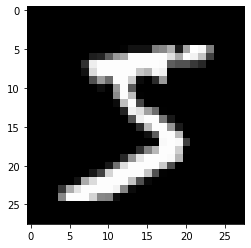

In [123]:
plt.imshow(mnist_train[0][0].reshape(28, 28), cmap="gray")
print("This is a {}".format(mnist_train.targets[0].numpy()))

In [137]:
def train(model, device, train_loader, batch_size, epochs):
    
    model.train()
    accuracies, losses = [], []
    
    criterion = nn.CrossEntropyLoss()#nn.NLLLoss(reduction='none')#
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0)
    
    for epoch in range(epochs):
        with tqdm(train_loader, unit="batch") as tepoch:
            for data, target in tepoch:
                
                data = data.reshape((batch_size, 28*28))
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                maxit = torch.argmax(output, dim=1)
                accuracy = (maxit==target).float().mean()
                
                loss = criterion(output, target)
                loss = loss
                losses.append(loss.item())
                accuracies.append(accuracy.item())
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss = loss.item())

    return losses, accuracies

def test(model, device, data_loader, num_labels, batch_size):
    
    model.eval()
    correct, total = np.zeros(num_labels), np.zeros(num_labels)
    
    for data in data_loader:
        inputs, labels = data
        inputs = inputs.reshape((batch_size, 28*28))
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()
        
        outputs = model(inputs)
        _,prediction = torch.max(outputs, 1)
        
        for i in range(num_labels):
            relevant = (labels==i)
            total[i] += relevant.sum().item()
            correct[i] += (prediction[relevant] == labels[relevant]).sum().item()
            
    return correct, total

class cheater_net(nn.Module):
    def __init__(self):
        super(cheater_net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128, bias=False)
        self.fc2 = nn.Linear(128, 10, bias=False)
        self.sm = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.sm(x)
        return x

In [138]:
cheater = cheater_net().to(device)
losses,accuracies = train(cheater, device, train_loader, batch_size, 5)

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable

accuracy:0.9717


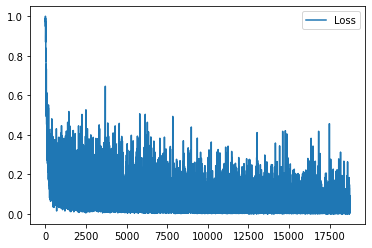

In [67]:
#plt.plot(accuracies, label="Accuracy")
plt.plot(losses/np.max(losses), label="Loss")
plt.legend()

num_labels = mnist_test.targets.unique().numel()
correct, total = test(cheater, device, test_loader, num_labels, batch_size)
print("accuracy:{}".format(correct.sum()/total.sum()))

# NumPy Only

Things we need

- Forward pass
- Backprop
- Loss function
- ReLU

### BackProp

**Crossentropy Cost, Softmax and derivatives**

$o^x_j:$ predicted probability of $x$ belonging to class $j$

$ t^x_j:$ target value of $x$ for output neuron $j$

Error $\large E_X = - \sum_k \left[ t_k^x \log(o_k^x) + (1-t_k^x) \log(1-o_k^x) \right]$

$\large \frac{\partial E_X}{\partial o_j^x} = -\frac{t_j^x}{o_j^x} + \frac{1 - t^x_j}{1-o_j^x}$

LogSoftMax derivative $\large \frac{\partial LS}{z} = 1 - e^{LSM(z)}$

In [2]:
x, y = fetch_openml('mnist_784', return_X_y=True)

Label=0


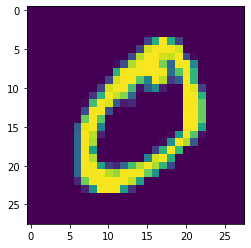

In [3]:
x = (x/255).astype('float32')
y = y.astype('int32')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=1)


x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()


print("Label={}".format(y[1]))
plt.imshow(x.iloc[1,:].to_numpy().reshape(28,28));

Input dot FC1
RELU(FC1)
FC1 dot FC2
LSM(FC2)
loss(LSM)

dx_lsm = output / lsm
d_fc2 = RELU(FC1).T dot dx_lsm
dx_relu = dx_lsm dot FC2.T


In [131]:
class MLP:
    
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.W1 = np.random.randn(input_size, hidden_size) / np.sqrt(input_size*hidden_size)
        self.W2 = np.random.randn(hidden_size, output_size) / np.sqrt(hidden_size*output_size)
        
    def forward(self, x, output):
        self.fc1 = np.dot(x, self.W1)
        self.relu1 = self.relu(self.fc1)
        self.fc2 = np.dot(self.relu1, self.W2)
        self.lsm = self.fc2 - self.logSoftmax(self.fc2).reshape((-1, 1))
        self.loss = np.mean(-output * self.lsm, axis=1)
        
    def logSoftmax(self, d):
        c = d.max(axis=1)
        return c + np.log(np.exp(d-c.reshape((-1, 1))).sum(axis=1))
        #return np.log( np.exp(d*g) / np.sum(np.exp(d*g)) )
    
    def relu(self, x):
        return np.maximum(x, 0)
    
    def crossEntropyLoss(self, p, y):
        """
        y: binary indicator for class-identity
        p: predicted probability observations belong to class
        """
        return -np.sum(y * np.log(p))
    
    def backward(self, x, y, output):

        self.d_output = -output / len(y)
        self.dx_lsm = self.d_output - np.exp(self.lsm) * self.d_output.sum(axis=1).reshape((-1,1))
        self.d_W2 = np.dot(self.relu1.T, self.dx_lsm)
        self.dx_relu = np.dot(self.dx_lsm, self.W2.T)
        self.dx_fc1 = (self.relu1>0).astype('float32') * self.dx_relu
        self.d_W1 = np.dot(x.T, self.dx_fc1)
        
    def evaluate(self, x, y):
        
        # Evaluate
        output_test = np.zeros((len(y), np.max(y+1)))
        output_test[range(len(y)), y] = 1    

        model.forward(x, output_test)
        ac = (np.argmax(model.lsm, axis=1) == y).sum() / len(y)
        print("Accuracy on test set = %.2f" % (ac))

In [132]:
model = MLP(28*28, 128, 10)

lr = 0.01
batch_size = 64
accuracies, losses = [], []

for i in trange(3000):
    
    # select batch-sized data
    idx = np.random.randint(0, high=x_train.shape[0], size=batch_size)
    x = x_train[idx,:]
    y = y_train[idx]
    
    output = np.zeros((batch_size, np.max(y_train+1)))
    output[range(batch_size), y] = 1    
    
    model.forward(x, output)
    loss = model.loss.copy()
    losses.append(loss.mean())
    accuracy = (np.argmax(model.lsm, axis=1) == y).sum() / batch_size
    accuracies.append(accuracy)
    model.backward(x, y, output)
    
    # SGD
    model.W1 -= model.d_W1*lr 
    model.W2 -= model.d_W2*lr
    

  0%|          | 0/3000 [00:00<?, ?it/s]

Accuracy on test set= 0.89


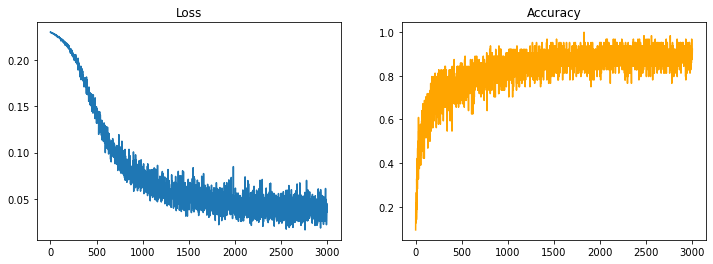

In [134]:
# Evaluate on test set
model.evaluate(x_test, y_test)

# Plot loss and accuracy across iterations
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(losses)
ax1.set_title("Loss")
ax2.plot(accuracies, color='orange')
ax2.set_title("Accuracy");

Accuracy on test set= 0.89


In [44]:
def logsumexp(x):
    #return np.log(np.exp(x).sum(axis=1))
    # http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    c = x.max(axis=1)
    return c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))

def forward_backward(x, y):
    # training
    out = np.zeros((len(y),10), np.float32)
    out[range(out.shape[0]),y] = 1

    # forward pass
    x_l1 = x.dot(l1)
    x_relu = np.maximum(x_l1, 0)
    x_l2 = x_relu.dot(l2)
    x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1))
    x_loss = (-out * x_lsm).mean(axis=1)
    print("x_l1, relu, x_l2", x_l1.shape, x_relu.shape, x_l2.shape)
    # training in numpy (super hard!)
    # backward pass

    # will involve x_lsm, x_l2, out, d_out and produce dx_sm
    d_out = -out / len(y)

    # derivative of logsoftmax
    # https://github.com/torch/nn/blob/master/lib/THNN/generic/LogSoftMax.c
    dx_lsm = d_out - np.exp(x_lsm)*d_out.sum(axis=1).reshape((-1, 1))

    # derivative of l2
    print(d_out.shape, out.shape, dx_lsm.shape)
    d_l2 = x_relu.T.dot(dx_lsm)
    print("l2.T", l2.T.shape, "dx_lsm", dx_lsm.shape)
    dx_relu = dx_lsm.dot(l2.T)

    # derivative of relu
    print(x_relu.shape, dx_relu.shape)
    dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu

    # derivative of l1
    d_l1 = x.T.dot(dx_l1)

    return x_loss, x_l2, d_l1, d_l2


In [45]:

# numpy training
def layer_init(m, h):
    # gaussian is strong
    #ret = np.random.randn(m,h)/np.sqrt(m*h)
    # uniform is stronger
    ret = np.random.uniform(-1., 1., size=(m,h))/np.sqrt(m*h)
    return ret.astype(np.float32)

# reinit
np.random.seed(1337)
l1 = layer_init(784, 128)
l2 = layer_init(128, 10)

samp = np.ones(32).astype("int")
x_loss, x_l2, d_l1, d_l2 = forward_backward(x_test[samp].reshape((-1, 28*28)), y_test[samp])

x_l1, relu, x_l2 (32, 128) (32, 128) (32, 10)
(32, 10) (32, 10) (32, 10)
l2.T (10, 128) dx_lsm (32, 10)
(32, 128) (32, 128)
